<h1 align=center>Data Analysis and Prediction</h1>

In [1]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from IPython.display import clear_output
import ipywidgets as widgets
import pyproj
import json as JSON

#### Import Data

In [2]:
df=pd.read_json("mapping.json",orient="table")

#### Seperate Data into Features and Target Variables

In [3]:
features=df.loc[:,'population':'AADT'].join(df['culturalFactor'])
targets=df.loc[:,'American Restaurant':'Steakhouse']
features=features.astype(float)
targets.head()

,American Restaurant,Asian Restaurant,Bakery/Dessert,Bar,Chinese Restaurant,Coffee Shop,Deli / Bodega,Diner,European Restaurant,Fast Food Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Latin American Restaurant,Middle Eastern Restaurant,Nightclub/Lounge,Pizza Place,Seafood Restaurant,Steakhouse
0,2,4,12,7,3,12,8,5,1,9,1,5,6,4,2,2,6,0,1
1,5,1,16,13,3,15,7,10,4,17,0,7,9,1,8,3,10,6,0
2,1,2,10,3,1,12,2,4,6,5,2,0,4,1,2,2,2,1,0
3,4,2,6,6,1,5,6,5,0,16,0,1,0,10,1,3,10,2,0
4,1,0,2,3,1,2,4,5,0,6,0,1,1,0,1,1,4,0,0


### Exploratory Data Analysis

### Supporting Plotting Functions

In [4]:
def heatMap(values,title=""):
    plt.figure(figsize=(20,1))
    plt.title(title,fontsize=16)
    plt.yticks(rotation=45)
    sns.heatmap(values,annot=True,cmap='coolwarm')

def univariatePlots(f,t=None,cols=3):
    if(type(f)!=DataFrame):
        f=DataFrame(f)
    if(type(t)==DataFrame or type(t)==Series):
        f=f.join(t)       
    rows=int(np.ceil(len(f.columns)/cols))
    fig,axes=plt.subplots(rows,cols,figsize=(18,rows*5))
    index=0
    if(rows==1):
        for x in axes:
            if(index<len(f.columns)):
                data=f.iloc[:,index] 
                sns.distplot(data,ax=x)
                x.legend([skew(data)])
                index+=1
            else:
                fig.delaxes(x)
    else:
        for i in axes:
            for x in i:
                if(index<len(f.columns)):
                    data=f.iloc[:,index] 
                    sns.distplot(data,ax=x)
                    x.legend([round(skew(data),4)])
                    index+=1
                else:
                    fig.delaxes(x)
    plt.show()
    
def plotFeatures(f,t,cols=3,deg=1):
    if(type(f)!=DataFrame):
        f=DataFrame(f)
    if(type(t)==pd.Series):
        corrs=f.corrwith(t)
        target=t
    corrs=pd.DataFrame(corrs).T  
    heatMap(corrs,"Feature Correlation with number of {}s in a place".format(target.name))
    rows=int(np.ceil(len(f.columns)/cols))
    fig,axes=plt.subplots(rows,cols,figsize=(18,rows*5))
    index=0
    if(rows==1):
        for x in axes:
            if(index<len(f.columns)):
                data=f.iloc[:,index] 
                sns.regplot(data,target,ax=x,order=deg)
                index+=1
            else:
                fig.delaxes(x)
    else:
        for i in axes:
            for x in i:
                if(index<len(f.columns)):
                    data=f.iloc[:,index]
                    x.set(xlim=(data.min()-data.std()/2,data.max()+data.std()/2))
                    x.set(ylim=(target.min()-target.std()/2,target.max()+target.std()/2))
                    sns.regplot(data,target,ax=x,order=deg)
                    index+=1
                else:
                    fig.delaxes(x)                       

from matplotlib.ticker import AutoMinorLocator                    
                    
def visualizeCV(name,*params,grouping='mean'):
    tmp=results[name]
    if(len(params)==0):
        params=list(tmp.columns[:-4])
    nrows=np.ceil(len(params)/3)
    fig=plt.figure(figsize=(18,5*nrows))
    fig.suptitle(name.upper(), fontsize=16)
    i=1
    for param in params:
#         param='param_'+param
        if param in tmp.columns:
            if grouping=='min':
                grp=tmp.groupby(param).min().reset_index()
            else:
                grp=tmp.groupby(param).mean().reset_index()
            axes=fig.add_subplot(nrows,3,i)
            axes.set(ylabel="Negative Root Mean Square Error")
            
            axes.xaxis.set_minor_locator(AutoMinorLocator())
            axes.yaxis.set_minor_locator(AutoMinorLocator())
            if(grp[param].dtype==object):
                m1=sns.barplot(grp[param],grp['mean_test_score'],ax=axes)
                m2=sns.barplot(grp[param],grp['mean_train_score'],ax=m1)
            else:
                m1=sns.lineplot(grp[param],grp['mean_test_score'],marker='o',ax=axes)
                m2=sns.lineplot(grp[param],grp['mean_train_score'],marker='o',ax=m1)
                m2.xaxis.grid(which='minor',linestyle='--',alpha=0.6)
                m2.grid(linestyle='-')
                if(grp[param].max()>=1000*grp[param].min() and grp[param].min()!=0):
                    m2.set(xscale="log")
#                     axes.xaxis.set_minor_locator(AutoMinorLocator())
            if(grp['mean_test_score'].max()>=1000*grp['mean_test_score'].min() and grp['mean_test_score'].min()!=0):
                m2.set(yscale="log")
#                 m2.yaxis.set_minor_locator(AutoMinorLocator())
            m2.set(ylabel="Root Mean Square Error")
            i+=1
        else:
            print('Parameter not applicable')
    plt.figlegend(labels=["Test Error","Train Error"])
    


def predictPlot(estimator,x_train, x_test, y_train, y_test,plot=True):
    testing=inverseLog(estimator.predict(x_test))
    training=inverseLog(estimator.predict(x_train))
    y_train=inverseLog(y_train)
    y_test=inverseLog(y_test)
    if (plot==True):
        plt.plot([0,y_train.max()],[0,y_train.max()],'--',color='black',alpha=0.5)
        plt.title(y_test.name)
        axis2=sns.scatterplot(x=y_train,y=training,cmap='g')
        axis1=sns.scatterplot(x=y_test,y=testing,cmap='r',ax=axis2)
        plt.legend(labels=["Mean Line","Train Values","Test Values"])
        axis2.set(xlabel="Actual Values",ylabel="Predicted Values")

In [5]:
from scipy.stats import skew,zscore,probplot
from sklearn.decomposition import PCA

def getTarget(target):
    if type(target)==str:
        return targets[target]
    else:
        return targets.iloc[:,target]
                   
def removeOutliers(f,t):
    f=DataFrame(f)
    rIndex=t[abs(zscore(t))>=3].index    
    print("Removing {} rows as Outliers:\n {}".format(len(rIndex),df.loc[rIndex,'name'].values))
    tF=f.drop(rIndex)#.reset_index(drop=True)
    tT=t.drop(rIndex)#.reset_index(drop=True)
    return tF,tT

def logTransform(f,t="None"):
    logF=np.log1p(f)
    if type(t)!=str:
        logT=np.log1p(t)
        return logF,logT
    return logF

def corr(df):
    plt.figure(figsize=(18,10))
    mask=mask = np.array(df.corr())
    mask[np.tril_indices_from(mask)] = False
    sns.heatmap(df.corr(),cmap='RdBu_r',annot=True,robust=True,mask=mask)
    plt.show()

def handleMulticollinearity(f,ratio=0.9):
    f=DataFrame(f)
    corrs=f.corr().replace(1.0,np.NaN)
    pca=PCA(1)
    tmp=f.copy()
    for i,col in corrs.iteritems():
        if col.max()>ratio:
            ind=(col[col==col.max()])  
            pcaValue=pca.fit_transform(tmp[[ind.index[0],ind.name]])
            if (pca.explained_variance_ratio_>0.9):
                tmp[ind.index[0]+"-"+ind.name]=pcaValue
                tmp.drop([ind.index[0],ind.name],inplace=True,axis=1)    
                tmp=handleMulticollinearity(tmp,ratio)
                break;
    return tmp

from sklearn.linear_model import LassoCV,RidgeCV,ElasticNetCV
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression

def topFeatures(X,y,n=0,method='Lasso'):
    if method=='Lasso':
        reg = LassoCV(cv=5,max_iter=5000)
        reg.fit(X, y)
        coef = pd.Series(reg.coef_, index = X.columns)
        if n==0:
            return coef[coef!=0],reg.score(X,y)            
        else:
            return coef.abs().sort_values(ascending=False)[:n],reg.score(X,y)
    
    if method=='ElasticNet':
        reg = ElasticNetCV(l1_ratio=np.arange(0.1,1.1,0.1),cv=5)
        reg.fit(X, y)
        coef = pd.Series(reg.coef_, index = X.columns)
        if n==0:
            return coef[coef!=0],reg.score(X,y)            
        else:
            return coef.abs().sort_values(ascending=False)[:n],reg.score(X,y)
        
    if method=='Ridge':
        reg = RidgeCV(cv=5)
        reg.fit(X, y)
        coef = pd.Series(reg.coef_, index = X.columns)
        if n==0:
            return coef[coef!=0],reg.score(X,y)            
        else:
            return coef.abs().sort_values(ascending=False)[:n],reg.score(X,y)
    else:
        coef = pd.Series(SelectKBest(f_regression,k=0).fit(X,y).scores_, index = X.columns)
        if n==0:
            return coef.sort_values(ascending=False)   
        else:
            return coef.sort_values(ascending=False)[:n]

In [6]:
def featureEngineering(f,t,
                       reduceSkew=True,
                       outliers=True,
                       multicollinearity=True,
                       multicollinearityRatio=1.0,
                       skewPlot=False,
                       targetPlot=False,
                       targetPlotDeg=1,
                       allTrue=False
                      ):
    tmpF=f.copy()
    tmpT=t.copy()
    if(allTrue==False):
        if(outliers==True):
            tmpF,tmpT=removeOutliers(tmpF,tmpT)
        if (reduceSkew==True):
            tmpF,tmpT=logTransform(tmpF,tmpT)
        if (multicollinearity==True):
            tmpF=handleMulticollinearity(tmpF,multicollinearityRatio)
        if skewPlot==True:
            univariatePlots(tmpF,tmpT)
        if targetPlot==True:
            plotFeatures(tmpF,tmpT,target,deg=targetPlotDeg)
    else:
        tmpF,tmpT=removeOutliers(tmpF,tmpT)
        tmpF,tmpT=logTransform(tmpF,tmpT)
        tmpF=handleMulticollinearity(tmpF,multicollinearityRatio)
        univariatePlots(tmpF,tmpT,cols=4)
        plotFeatures(tmpF,tmpT,deg=targetPlotDeg)
    return tmpF,tmpT

In [7]:
%%capture #--no-stdout --no-display
# Used Not to print warnings and debugs

models=[]
bestScore=0
for ratio in [0.8,0.9,1.0]:
    for outs in [True,False]:
        for skew in [True,False]:
            for model in ['Lasso','Ridge','ElasticNet']:
                x,y=featureEngineering(features,getTarget(0),outliers=outs,reduceSkew=skew,multicollinearityRatio=ratio)
                feature,score=topFeatures(x,y,method=model)
                data={'model':model,
                      'logTransformed':skew,
                      'Outliers Removed':outs,
                      'Pca Ratio':ratio,
                      'Score':score,
#                       'Features':feature
                     }
                models.append(data)
                if score>bestScore:
                    bestScore=score
                    best=data                

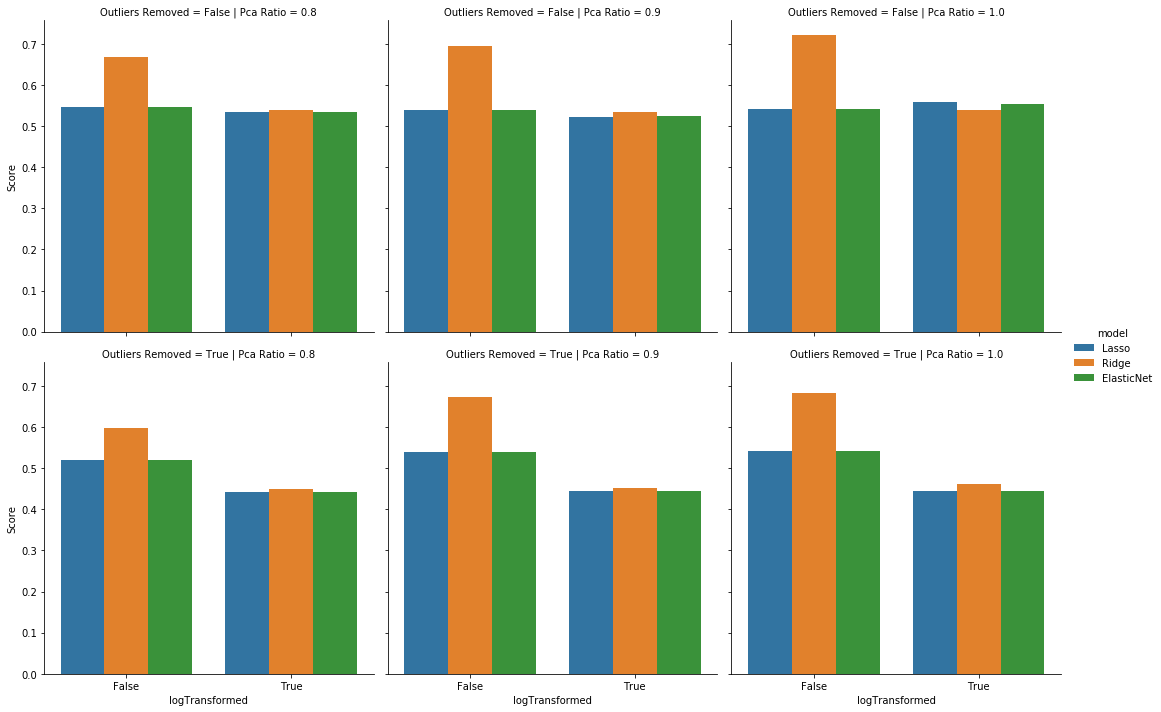

{'model': 'Ridge',
 'logTransformed': False,
 'Outliers Removed': False,
 'Pca Ratio': 1.0,
 'Score': 0.7210273207938109}

In [8]:
sns.catplot(x='logTransformed',y='Score',data=pd.DataFrame(models),
            col='Pca Ratio',
            row='Outliers Removed',
            kind='bar',
            hue='model',
            sharey=True,
           )
plt.show()
best

## Machine Learning

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor,AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import ElasticNet,LinearRegression,Ridge,Lasso
from sklearn.metrics import mean_squared_error,mean_squared_log_error,r2_score,make_scorer
from sklearn.preprocessing import PolynomialFeatures,RobustScaler,StandardScaler,FunctionTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV,KFold,train_test_split,RandomizedSearchCV
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve,validation_curve
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#### Metrics and Transformation Functions

In [10]:
def inverseLog(series,series1="None"):
    if type(series1)!=str:
        return np.expm1(series),np.expm1(series1)
    return np.expm1(series)

from sklearn.metrics.regression import check_consistent_length

def RMSE(yTrue,yPred):
    check_consistent_length(yTrue, yPred)  
    return np.sqrt(np.mean((np.expm1(yTrue)-np.expm1(yPred))**2))
RmseScorer=make_scorer(RMSE,greater_is_better=False)

def resultMetrics(yTrue,yPred):
    yTrue,yPred=inverseLog(yTrue,yPred)
    return r2_score(yTrue,yPred),np.sqrt(mean_squared_error(yTrue,yPred)),np.std(yTrue-yPred)

### Preprocessing

In [11]:
X=features.copy()
y=getTarget(0)

X,y=logTransform(X,y)
X,y=removeOutliers(X,y)
X=handleMulticollinearity(X,0.9)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=33)

Removing 0 rows as Outliers:
 []


### Basic Regressors and Cross-validated Hyper-parameter Tuning

In [12]:
parameters={}
results={}
estimators={}

In [13]:
def Optimizer(estimator,name,params,X=x_train,y=y_train,cv=10,method='Grid'):
    if (name not in parameters.keys() or name not in estimators.keys() or params!=parameters[name]):
        kf=KFold(cv,shuffle=True,random_state=34)
        parameters.update({name:params})
        if(method=='Random' and len(params.keys())>5):
            opt=RandomizedSearchCV(estimator,param_distributions=parameters[name],n_iter=1000,cv=kf,iid=False,scoring=RmseScorer,random_state=0,return_train_score=True,n_jobs=-1)             
        elif method=='Random':
            opt=RandomizedSearchCV(estimator,param_distributions=parameters[name],n_iter=500,cv=kf,iid=False,scoring=RmseScorer,random_state=0,return_train_score=True,n_jobs=-1)
        else:
            opt=GridSearchCV(estimator,param_grid=parameters[name],cv=kf,iid=False,scoring=RmseScorer,n_jobs=-1,return_train_score=True)
        opt.fit(X,y)
        tmp=DataFrame(opt.cv_results_)
        tmp.drop(tmp.columns[:4],axis=1,inplace=True)
        keep=[('std' in i)or('mean' in i)or('param_' in i) for i in tmp.columns]
        tmp=tmp.loc[:,keep]
        tmp[['mean_test_score','mean_train_score']]=tmp[['mean_test_score','mean_train_score']].abs()
        results.update({name:tmp})
        estimators.update({name:opt})
    else:
        opt=estimators[name]
    print(name.upper())
    print("Best Parameters:{}\nBest Score:{}".format(opt.best_params_,opt.best_score_))
    return opt.best_estimator_

In [37]:
linear=Pipeline([('poly',PolynomialFeatures()),('scaler',StandardScaler()),('reg',LinearRegression())])
elastic=Pipeline([('poly',PolynomialFeatures()),('scaler',StandardScaler()),('reg',ElasticNet())])
decisionTree=Pipeline([('poly',PolynomialFeatures()),('scaler',StandardScaler()),('reg',DecisionTreeRegressor())])
randomForest=Pipeline([('poly',PolynomialFeatures()),('scaler',StandardScaler()),('reg',RandomForestRegressor())])
gradientBoosting=Pipeline([('poly',PolynomialFeatures()),('scaler',StandardScaler()),('reg',GradientBoostingRegressor())])
bagging=Pipeline([('poly',PolynomialFeatures()),('scaler',StandardScaler()),('reg',BaggingRegressor())])
svr=Pipeline([('poly',PolynomialFeatures()),('scaler',StandardScaler()),('reg',SVR())])
xgb=Pipeline([('poly',PolynomialFeatures()),('scaler',StandardScaler()),('reg',XGBRegressor(objective='reg:squarederror'))])
lgbm=Pipeline([('poly',PolynomialFeatures()),('scaler',StandardScaler()),('reg',LGBMRegressor())])

In [15]:
degrees=[1,2]
zeroToOne=list(np.arange(0,1.1,0.1))
pointToOne=list(np.arange(0.1,1.1,0.1))

LINEAR
Best Parameters:{'poly__degree': 1}
Best Score:-2.7600534923891495

Test Set:
R2 Score:0.4838178424201698, Root Mean Square Error:5.2355227025244035, Standard Deviation of Error:4.9397008514030665


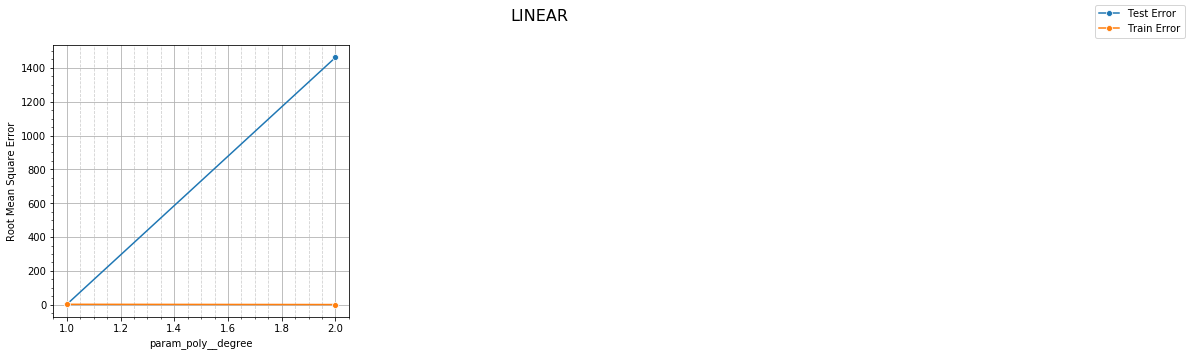

In [19]:
params={'poly__degree':degrees}

Linear=Optimizer(linear,'linear',params,x_train,y_train)
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,Linear.predict(x_test))))
visualizeCV('linear')

ELASTICNET
Best Parameters:{'reg__l1_ratio': 1.0, 'reg__alpha': 0.00023357214690901214, 'poly__degree': 1}
Best Score:-2.759965374537017

Test Set:
R2 Score:0.48411285835027473, Root Mean Square Error:5.234026347669056, Standard Deviation of Error:4.938368415070096


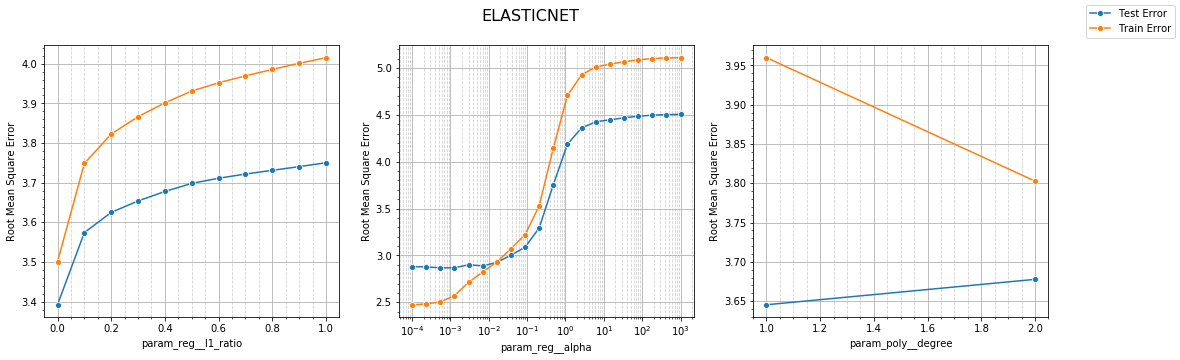

In [20]:
%%capture --no-stdout --no-display

alphas=list(np.logspace(-4,3,20))

params={
        'poly__degree':degrees,
        'reg__alpha':alphas,
        'reg__l1_ratio':zeroToOne,
       }

Elastic=Optimizer(elastic,'elasticNet',params,x_train,y_train,method="Random",cv=10)
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,Elastic.predict(x_test))))
visualizeCV('elasticNet',grouping='')

SVR
Best Parameters:{'reg__gamma': 0.0012742749857031334, 'reg__epsilon': 0.01623776739188721, 'reg__C': 2.6366508987303554, 'poly__degree': 2}
Best Score:-2.6116176181498254

Test Set:
R2 Score:0.6821723606873358, Root Mean Square Error:4.108226540302164, Standard Deviation of Error:3.9624978761047958


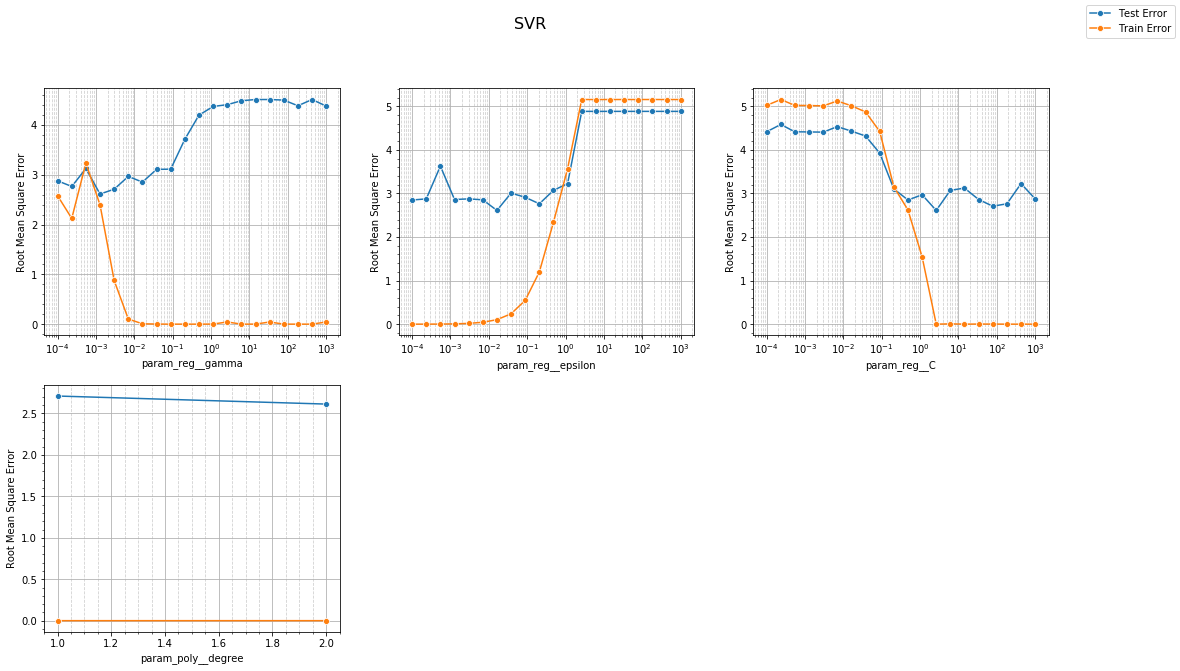

In [32]:
params={
        'poly__degree':degrees,
        'reg__gamma':alphas, #alpha=logspace(-4,3,20)
        'reg__C':alphas,
        'reg__epsilon':alphas,
       }

Svr=Optimizer(svr,'svr',params,x_train,y_train,cv=10,method="Random")
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,Svr.predict(x_test))))
visualizeCV('svr',grouping='min')

DECISIONTREE
Best Parameters:{'reg__min_samples_leaf': 10, 'reg__min_impurity_decrease': 0, 'reg__max_features': 'auto', 'reg__max_depth': 3, 'poly__degree': 1}
Best Score:-2.925578831285889

Test Set:
R2 Score:0.5278749933833997, Root Mean Square Error:5.0071091052362755, Standard Deviation of Error:4.86666539083278


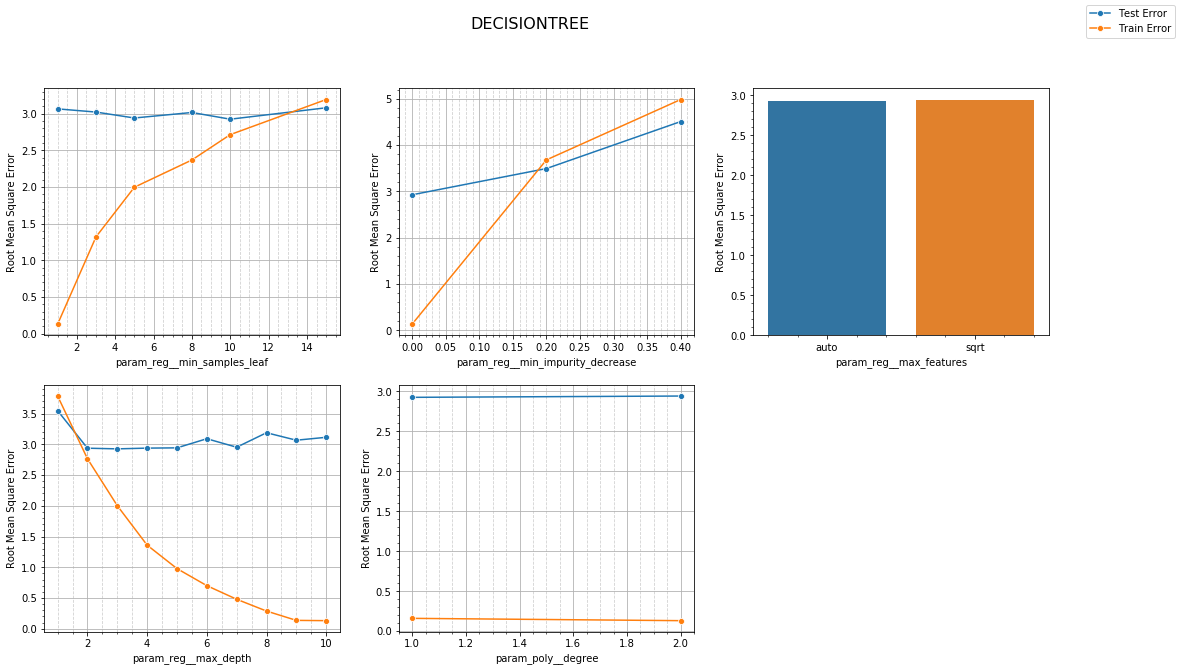

In [21]:
depths=list(np.arange(1,11,1))

params={'poly__degree':degrees,
        'reg__max_depth':depths,
        'reg__min_samples_leaf':[1,3,5,8,10,15],
        'reg__min_impurity_decrease':[0,0.2,0.4],
        'reg__max_features':['auto','sqrt']
       }

DecisionTree=Optimizer(decisionTree,'decisionTree',params,x_train,y_train,method="Random")

print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,DecisionTree.predict(x_test))))
visualizeCV('decisionTree',grouping='min')

RANDOMFOREST
Best Parameters:{'reg__n_estimators': 10, 'reg__min_samples_split': 5, 'reg__min_samples_leaf': 1, 'reg__max_features': 'sqrt', 'reg__max_depth': 4, 'poly__degree': 2}
Best Score:-2.7516066207513097

Test Set:
R2 Score:0.5532447433314627, Root Mean Square Error:4.87072251444242, Standard Deviation of Error:4.641293212798819


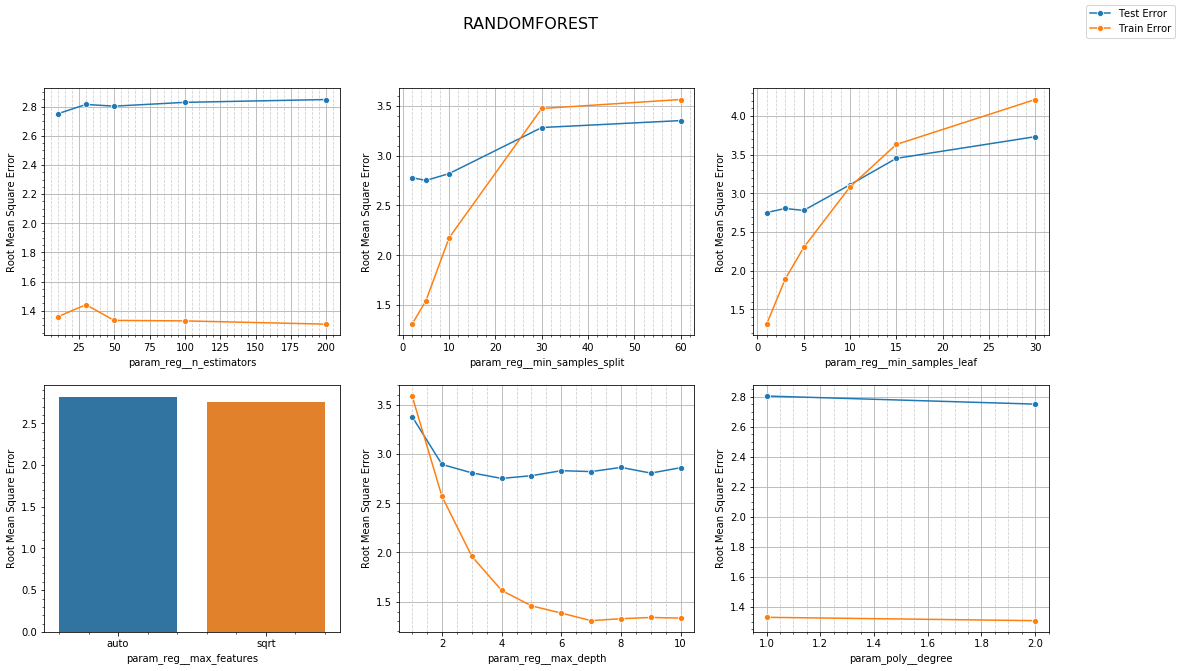

In [30]:
params={'poly__degree':degrees,
        'reg__max_depth':depths,
        'reg__min_samples_leaf':[1,3,5,10,15,30],
        'reg__n_estimators':[10,30,50,100,200],
        'reg__max_features':['auto','sqrt'],
        'reg__min_samples_split':[2,5,10,30,60],
       }

RandomForest=Optimizer(randomForest,'randomForest',params,x_train,y_train,method="Random")

print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,RandomForest.predict(x_test))))

visualizeCV('randomForest',grouping='min')

GRADIENTBOOSTING
Best Parameters:{'reg__n_estimators': 100, 'reg__min_samples_split': 30, 'reg__min_samples_leaf': 15, 'reg__max_features': 'auto', 'reg__max_depth': 8, 'reg__learning_rate': 0.2, 'poly__degree': 1}
Best Score:-2.6577383622876005

Test Set:
R2 Score:0.6166481016143277, Root Mean Square Error:4.511878145950759, Standard Deviation of Error:4.30989964106689


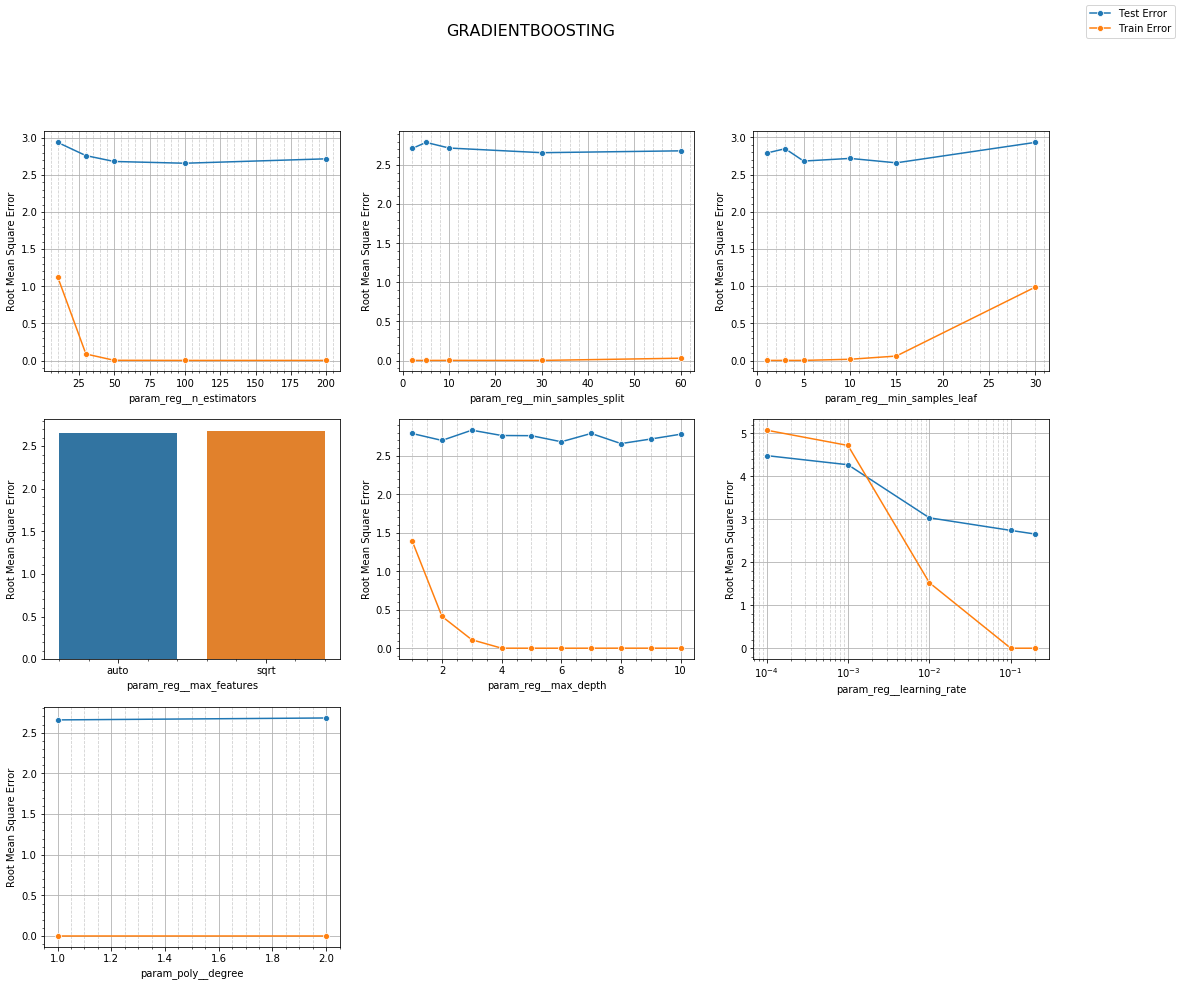

In [24]:
params={'poly__degree':degrees,
        'reg__max_depth':depths,
        'reg__min_samples_leaf':[1,3,5,10,15,30],
        'reg__n_estimators':[10,30,50,100,200],
        'reg__min_samples_split':[2,5,10,30,60],
        'reg__max_features':['auto','sqrt'],
        'reg__learning_rate':[0.0001,0.001,0.01,0.1,.2],
       }

GradientBoosting=Optimizer(gradientBoosting,'gradientBoosting',params,x_train,y_train,method="Random")
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,GradientBoosting.predict(x_test))))
visualizeCV('gradientBoosting',grouping='min')

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGB
Best Parameters:{'reg__subsample': 0.5, 'reg__n_estimators': 30, 'reg__min_child_weight': 1, 'reg__max_depth': 5, 'reg__learning_rate': 0.2, 'poly__degree': 1}
Best Score:-2.691799720126536

Test Set:
R2 Score:0.7639223848261331, Root Mean Square Error:3.5406741275725966, Standard Deviation of Error:3.448680477545691


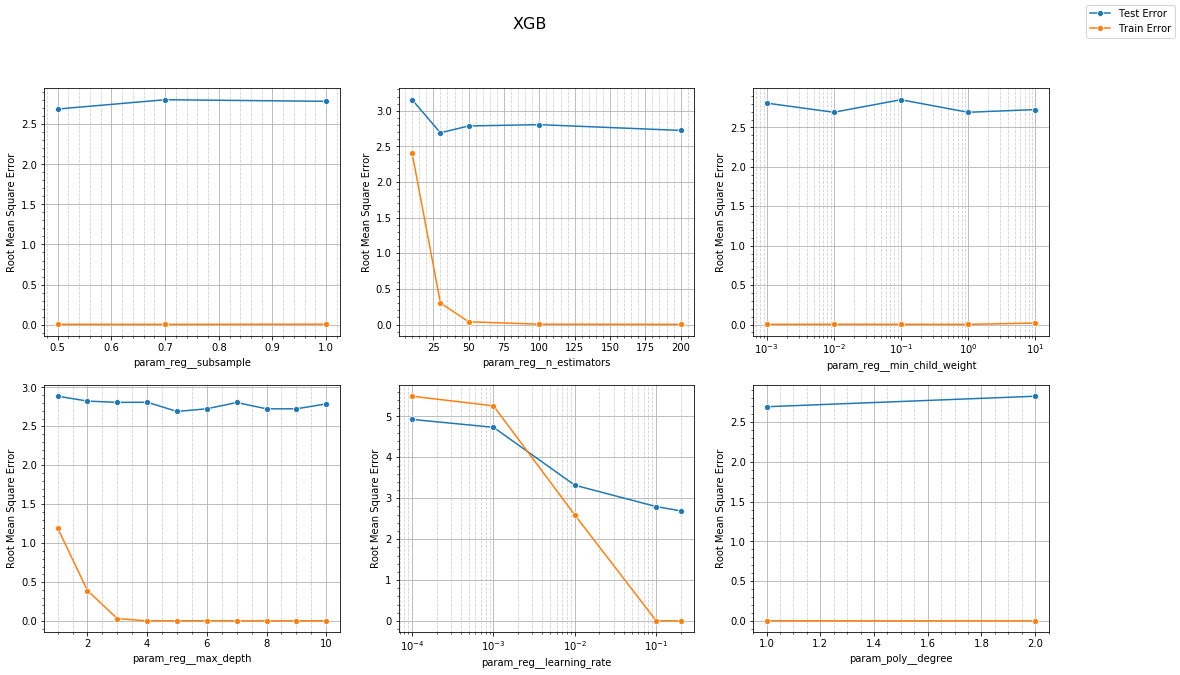

In [36]:
params={'poly__degree':degrees,
        'reg__max_depth':depths,
        'reg__n_estimators':[10,30,50,100,200],
        'reg__learning_rate':[0.0001,0.001,0.01,0.1,.2],
        'reg__min_child_weight':[0.001,0.01,0.1,1,10],
        'reg__subsample':[0.5,0.7,1.0]
       }

XGB=Optimizer(xgb,'xgb',params,x_train,y_train,cv=10,method="Random")
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,XGB.predict(x_test))))
visualizeCV('xgb',grouping='min')

LGBM
Best Parameters:{'reg__num_leaves': 100, 'reg__n_estimators': 30, 'reg__min_child_weight': 0.0001, 'reg__min_child_samples': 10, 'reg__learning_rate': 0.2}
Best Score:-2.754659113455512

Test Set:
R2 Score:0.6050292154114963, Root Mean Square Error:4.579742279432902, Standard Deviation of Error:4.388091520471703


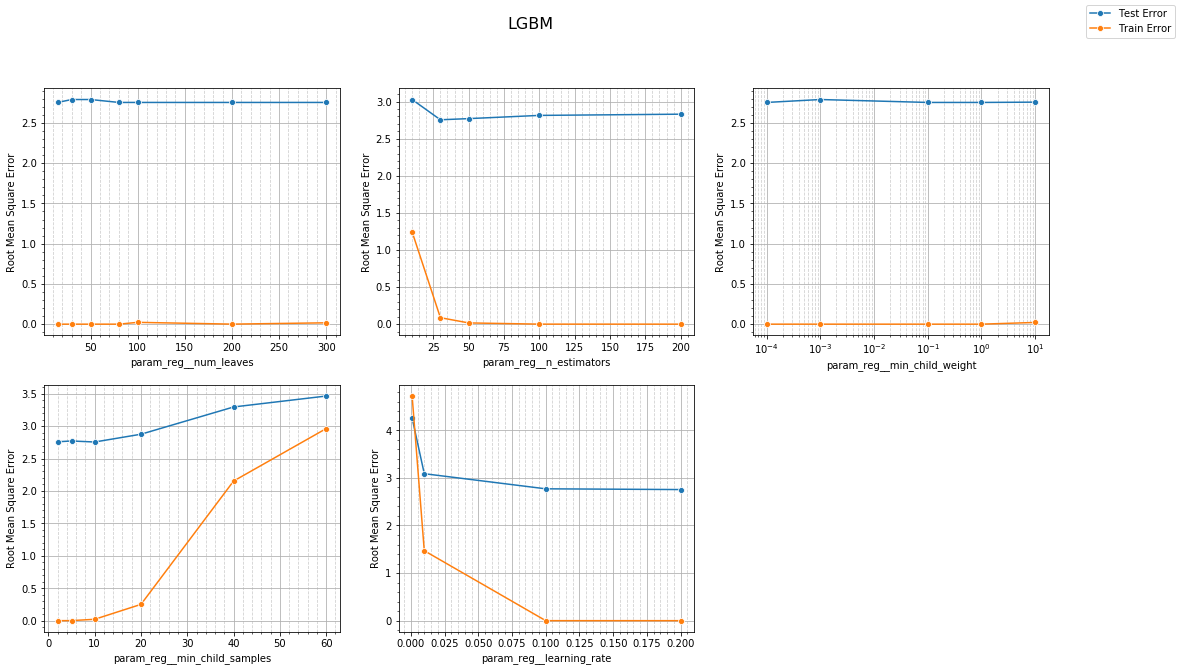

In [47]:
params={
#         'poly__degree':degrees,
        'reg__min_child_samples':[2,5,10,20,40,60],
        'reg__n_estimators':[10,30,50,100,200],
        'reg__learning_rate':[0.001,0.01,0.1,.2],
        'reg__min_child_weight':[0.0001,0.001,0.1,1,10],
        'reg__num_leaves':[15,30,50,80,100,200,300]
       }

LGBM=Optimizer(lgbm,'lgbm',params,x_train,y_train,cv=10,method="Random")
print("\nTest Set:\nR2 Score:{}, Root Mean Square Error:{}, Standard Deviation of Error:{}".
      format(*resultMetrics(y_test,LGBM.predict(x_test))))
visualizeCV('lgbm',grouping='min')

In [35]:
lgbm.get_params()
# xgb.fit(x_train,y_train)
# resultMetrics(y_test,xgb.predict(x_test))
# pr=XGBRegressor(max_depth=1,learning_rate=0.2,n_estimators=5000,subsample=1,objective='reg:squarederror').fit(x_train,y_train).predict(x_test)
# resultMetrics(y_test,pr)

{'memory': None,
 'steps': [('poly',
   PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                      order='C')),
  ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('reg',
   LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                 importance_type='split', learning_rate=0.1, max_depth=-1,
                 min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                 n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                 random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                 subsample=1.0, subsample_for_bin=200000, subsample_freq=0))],
 'verbose': False,
 'poly': PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                    order='C'),
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'reg': LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
           

In [27]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(0.05, 1.0, 20)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#### Basic and Regualrized Linear Regression models

Elastic Net can be used in place of Ridge and Lasso Regression models because the it has a combination of the L1 and L2 penalization terms and uses alpha for the co-efficients. A basic Linear Regression model is also considered for analysis.

### Results

In [28]:
from bokeh.plotting import figure,show,ColumnDataSource
from bokeh.io import output_file, output_notebook, show
from bokeh.tile_providers import get_provider, Vendors
output_notebook()

src=ColumnDataSource(outDf)

tile_provider = get_provider(Vendors.CARTODBPOSITRON)

p = figure(x_range=(-8266167.768358,-8203221.875565), y_range=(4937793.808708,5008765.589471),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(tile_provider)
p.patches(xs='merc_x',ys='merc_y',source=src,)

show(p)

Loading BokehJS ...

NameError: name 'outDf' is not defined